# Topic modelling

In [1]:
from enisa_elastic.elastic import elastic_to_df

df = elastic_to_df('websites')
#df = elastic_to_df('rssfeeds')

Total number of entries: 14655


[========================================================================] 100%


Turning the _source items into columns.


In [2]:
print(len(df))
df.columns

14655


Index(['_id', '_score', 'resource_link', 'title', 'link', 'resource_label',
       'content', 'published'],
      dtype='object')

In [86]:
df.head()

,_id,_score,resource_link,title,link,resource_label,content,published
0,61600cc7bdc83a25bc15adc74eb4902a538092a1,None,https://www.bankinfosecurity.com/latest-news,Report: US Government Preps WikiLeaks Charges,https://www.bankinfosecurity.com/blogs/report-...,bankinfosecurity,As U.S. government officials continue to ramp ...,2017-04-21T00:00:00
1,54f4ff6018e1858688ef91e15172ad77d633c10f,None,https://www.bankinfosecurity.com/latest-news,Cybersecurity Startup Exposed Hospital Network...,https://www.bankinfosecurity.com/cybersecurity...,bankinfosecurity,Billion-dollar cybersecurity startup Tanium ha...,2017-04-20T00:00:00
2,b8499fa0a8bab6ad912a58193d773154e2cd3ef9,None,https://www.bankinfosecurity.com/latest-news,A CISO's First 100 Days,https://www.bankinfosecurity.com/interviews/ci...,bankinfosecurity,"For a security leader, the first three months ...",2016-09-09T00:00:00
3,c95a2283caf7a7ccb4622439f39a4ca32c292254,None,https://www.bankinfosecurity.com/latest-news,Financial Sector Under Increasing Cybercrime T...,https://www.bankinfosecurity.com/financial-sec...,bankinfosecurity,The financial sector is under increasing threa...,2017-11-09T00:00:00
4,a64c4867f697cf23d3d76a00d961d655ceb9174b,None,https://www.bankinfosecurity.com/latest-news,Exclusive: Aussie Firm Loses $6.6M to Backdoor...,https://www.bankinfosecurity.com/exclusive-aus...,bankinfosecurity,Australian police in Queensland are pursuing a...,2018-06-05T00:00:00


In [136]:
#print(len(df[df['description'] == '']))
print("Number of documents with empty content:", len(df[df['content'] == '']))

Number of documents with empty content: 21


In [137]:
df_recent = df[df["published"] > "2018-05-01"]
len(df_recent)

375

In [231]:
X0 = df_recent["content"]

In [232]:
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer 

ps = PorterStemmer()

def tokenizer(text):
    #return [ps.stem(w).lower() for w in word_tokenize(text) if w.isalpha() and len(w)>1]
    return [w.lower() for w in word_tokenize(text) if w.isalpha() and len(w)>1]

In [233]:
from nltk.corpus import stopwords

# Show the English stop words.
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [234]:
# Number of clusters
n = 5

# Number of features, ordered by term frequency
m = 5

In [235]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv_max = TfidfVectorizer(lowercase=True, stop_words='english',
                         tokenizer=tokenizer, max_df=0.1, min_df=0.001, max_features=100)

In [236]:
from time import time

t0 = time()
X = tv_max.fit_transform(X0)
print("done in %0.3fs." % (time() - t0))
print("Shape of the X matrix:", X.shape)

done in 1.903s.
Shape of the X matrix: (375, 100)


In [237]:
import numpy as np

freq_pairs  = list(zip(tv_max.get_feature_names(), np.asarray(X.mean(axis=0)).ravel()))
sorted(freq_pairs, key = lambda x: x[1], reverse=True)[:10]

[('bank', 0.043243036429970474),
 ('gdpr', 0.042349518720288075),
 ('series', 0.038781330326429275),
 ('identity', 0.038627711398662092),
 ('facebook', 0.033719659609740681),
 ('chrome', 0.033164041496767369),
 ('github', 0.03262552673814588),
 ('intel', 0.030681121504640505),
 ('routers', 0.029581158774277128),
 ('police', 0.028375384188546151)]

In [238]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=n)
t0 = time()
km.fit(X)
print("done in %0.3fs." % (time() - t0))

done in 0.241s.


In [239]:
import pprint

pp = pprint.PrettyPrinter()

print("Cluster center coordinates:")
print("---------------------------")
for c in km.cluster_centers_:
    freq_pairs = list(zip(tv_max.get_feature_names(), c))
    pp.pprint(sorted(freq_pairs, key = lambda x: x[1], reverse=True)[:m])

Cluster center coordinates:
---------------------------
[('series', 0.07399700364877751),
 ('intel', 0.071462239529442168),
 ('chrome', 0.069391702639799518),
 ('insider', 0.059520266067996014),
 ('amazon', 0.051447895561364136)]
[('routers', 0.083405522859803932),
 ('facebook', 0.080477206191586714),
 ('github', 0.077160271833344132),
 ('iot', 0.065875015888866267),
 ('fbi', 0.064491913629193126)]
[('gdpr', 0.66289112538029804),
 ('eu', 0.30986173099664277),
 ('identity', 0.079397137631794137),
 ('bank', 0.07873082153654086),
 ('healthcare', 0.071125525774508161)]
[('stackcommerce', 0.70958667025814337),
 ('deal', 0.53325011716980764),
 ('bundle', 0.35823852971700287),
 ('policy', 0.093469746167160986),
 ('credit', 0.07649576297165385)]
[('bank', 0.29790858593269315),
 ('payments', 0.20406851535101844),
 ('payment', 0.15559762606823749),
 ('card', 0.13915358641807854),
 ('banks', 0.1156158635443021)]


In [240]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(lowercase=True, stop_words='english',
                     tokenizer=tokenizer, max_df=0.1, min_df=0.001)

In [241]:
t0 = time()
X = tv.fit_transform(X0)
print("done in %0.3fs." % (time() - t0))
print("Shape of the X matrix:", X.shape)

done in 1.907s.
Shape of the X matrix: (375, 10301)


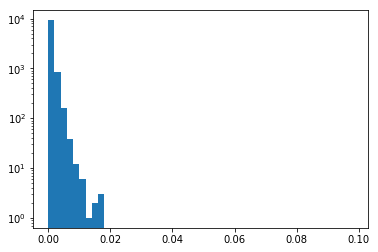

In [242]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(np.asarray(X.mean(axis=0)).flatten(), bins=np.arange(0, 0.1, 0.1/50))
plt.yscale('log', nonposy='clip')
plt.show()

In [243]:
t0 = time()
km.fit(X)
print("done in %0.3fs." % (time() - t0))

done in 2.551s.


In [244]:
print("Cluster center coordinates:")
print("---------------------------")
for c in km.cluster_centers_:
    freq_pairs = list(zip(tv.get_feature_names(), c))
    pp.pprint(sorted(freq_pairs, key = lambda x: x[1], reverse=True)[:m])

Cluster center coordinates:
---------------------------
[('chrome', 0.13222217888360979),
 ('firefox', 0.090105832367066971),
 ('intel', 0.077489697315631559),
 ('spectre', 0.056352983762268195),
 ('mozilla', 0.043494644487241316)]
[('stackcommerce', 0.47318435908903506),
 ('deal', 0.36135888185385717),
 ('bundle', 0.25265836241766337),
 ('courses', 0.15185251295586366),
 ('training', 0.11521779558776056)]
[('facebook', 0.023405115856072661),
 ('gdpr', 0.018190131841339201),
 ('routers', 0.017909186426920225),
 ('github', 0.0154456382575956),
 ('apple', 0.014424549762064335)]
[('series', 0.11022142513535325),
 ('watch', 0.080419539231276149),
 ('discuss', 0.079422125585749237),
 ('startup', 0.077418634430536051),
 ('startups', 0.06511636027356274)]
[('bank', 0.088449096428089888),
 ('haran', 0.066991877518901691),
 ('identity', 0.053107965227105508),
 ('conferences', 0.048641781871597026),
 ('events', 0.044201340417305127)]


In [245]:
def print_top_words(model, feature_names, n_top_words):
    keywords = []
    for topic_idx, topic in enumerate(model.components_):
        s = "Topic #%d: " % topic_idx
        s += ", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(s)
        keywords.append([feature_names[i]
                         for i in topic.argsort()[:-n_top_words - 1:-1]])
    return keywords

In [246]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(lowercase=True, stop_words='english',
                     tokenizer=tokenizer, max_df=0.1, min_df=0.001)

In [247]:
t0 = time()
X = cv.fit_transform(X0)
print("done in %0.3fs." % (time() - t0))
print("Shape of the X matrix:", X.shape)

done in 1.998s.
Shape of the X matrix: (375, 10301)


In [248]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=n, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(X)
print("done in %0.3fs." % (time() - t0))

done in 1.236s.


In [249]:
print("Topics in LDA model:")
print("--------------------")
feature_names = cv.get_feature_names()
keywords = print_top_words(lda, feature_names, m)

Topics in LDA model:
--------------------
Topic #0: gdpr, eu, schulte, ghostery, regulation
Topic #1: intel, variant, github, ransom, spectre
Topic #2: facebook, bank, banks, zuckerberg, gdpr
Topic #3: summit, haran, conferences, edition, clipboard
Topic #4: chrome, routers, firefox, amazon, apple


In [250]:
from enisa_elastic.elastic import es

In [251]:
for c in range(n):
    query = " OR ".join(keywords[c])    
    res = es.search(index="websites", body={"query": {"match": {"content": query}}}, size=10)
    print("Titles from cluster {}".format(c))
    print("---------------------")
    for i in range(10):
        print(res['hits']['hits'][i]['_source']['title'])
        #print(res['hits']['hits'][i]['_score'])
    print()

Titles from cluster 0
---------------------
New Service Blocks EU Users So Companies Can Save Thousands on GDPR Compliance
Ghostery Tries to Comply With GDPR, but Ends Up Violating GDPR in the Process
Microsoft Will Extend GDPR Privacy Protections to All Users, Not Just Europeans
EU to Simplify Those Pesky Cookie Warning Popups, but Not Remove Them
UK Law Proposal to Criminalize Re-Identification of Anonymized User Data
Europe's Strong GDPR Privacy Rules Go Into Full Effect
Data Privacy After Brexit: Keep Calm and GDPR On
GDPR Enforcement Deadline: If You Blew It, What's Next?
The Impact of GDPR Even If You Are Not In The EU
The Road to GDPR Compliance: 12 Steps to Take Now

Titles from cluster 1
---------------------
Google and Microsoft Reveal New Spectre Attack
New Spectre Attack Recovers Data From a CPU's Protected SMM Mode
Microsoft Patch Nukes Bad Intel Firmware Fix
Microsoft Issues Windows Out-of-Band Update That Disables Spectre Mitigations
Spectre and Meltdown Flaws: Two More 

In [252]:
t0 = time()
X = tv.fit_transform(X0)
print("done in %0.3fs." % (time() - t0))
print("Shape of the X matrix:", X.shape)

done in 2.184s.
Shape of the X matrix: (375, 10301)


In [253]:
lda = LatentDirichletAllocation(n_components=n, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(X)
print("done in %0.3fs." % (time() - t0))

done in 0.818s.


In [254]:
print("Topics in LDA model:")
print("--------------------")
feature_names = tv.get_feature_names()
keywords = print_top_words(lda, feature_names, m)

Topics in LDA model:
--------------------
Topic #0: gdpr, eu, apple, variant, controller
Topic #1: intel, github, spectre, series, apple
Topic #2: facebook, firefox, mozilla, haran, chrome
Topic #3: insider, clipboard, bank, payments, kaspersky
Topic #4: stackcommerce, deal, chrome, bundle, routers


In [255]:
for c in range(n):
    query = " OR ".join(keywords[c])    
    res = es.search(index="websites", body={"query": {"match": {"content": query}}}, size=10)
    print("Titles from cluster {}".format(c))
    print("---------------------")
    for i in range(10):
        print(res['hits']['hits'][i]['_source']['title'])
        #print(res['hits']['hits'][i]['_score'])
    print()

Titles from cluster 0
---------------------
Apple Is Cracking Down on Apps That Share Geolocation Data With Third Parties
Leaked Image Shows Microsoft's New Xbox Accessibility Controller
New Service Blocks EU Users So Companies Can Save Thousands on GDPR Compliance
EU Prepares "Right to Repair" Legislation to Fight Short Product Lifespans
Data Privacy After Brexit: Keep Calm and GDPR On
Europe's Strong GDPR Privacy Rules Go Into Full Effect
GDPR Enforcement Deadline: If You Blew It, What's Next?
EU GDPR: The Why and How for Financial Services
GDPR a Litmus Test for Cross-Border Privacy Attitudes
The Impact of GDPR Even If You Are Not In The EU

Titles from cluster 1
---------------------
Apple: All Mac Systems and iOS Devices Are Affected by Meltdown & Spectre Flaws
User-Made Patch Lets Owners of Next-Gen CPUs Install Updates on Windows 7 & 8.1
Apple Releases Security Updates for Spectre CPU Flaw
Intel Reveals Some CPU Models Will Never Receive Microcode Updates
SgxSpectre Attack Can E

In [256]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=n, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5)
t0 = time()
nmf.fit(X)
print("done in %0.3fs." % (time() - t0))

done in 0.853s.


In [257]:
print("Topics in NMF model (generalized Kullback-Leibler divergence):")
print("--------------------------------------------------------------")
feature_names = tv.get_feature_names()
keywords = print_top_words(nmf, feature_names, m)

Topics in NMF model (generalized Kullback-Leibler divergence):
--------------------------------------------------------------
Topic #0: required, reason, deal, sees, policy
Topic #1: issued, small, sure, routers, longer
Topic #2: summit, watch, topics, stint, value
Topic #3: regulation, audio, gdpr, eu, recognition
Topic #4: shown, chrome, macos, showing, toshiba


In [258]:
for c in range(n):
    query = " OR ".join(keywords[c])    
    res = es.search(index="websites", body={"query": {"match": {"content": query}}}, size=10)
    print("Titles from cluster {}".format(c))
    print("---------------------")
    for i in range(10):
        print(res['hits']['hits'][i]['_source']['title'])
        #print(res['hits']['hits'][i]['_score'])
    print()

Titles from cluster 0
---------------------
New Deal: 96% off a Ethical Hacking A to Z Course Bundle
New Offer: 98% off the Ultimate CompTIA+ Certification Bundle
Today's Deal: 94% off a Reactive JavaScript Course & eBook Bundle
Get 92% off a Microsoft Azure Mastery Bundle Deal
New Deal: 97% off the CompTIA Core Certification Bundle
New Deal: 94% off the Full Stack JavaScript Bundle
New Deal: 95% off the The Complete C Programming Bonus Bundle
Today's Deal: 96% off a Xamarin Cross Platform Development Bundle
New Deal: 91% off the Zero to Hero Cyber Security Hacker Bundle
Today's Deal: 98% off The Ultimate DevOps and Cloud Computing Bundle

Titles from cluster 1
---------------------
FBI Seizes Domain Controlling 500,000 Compromised Routers
Bizarre attack infects Linksys routers with self-replicating malware
12 million home and business routers vulnerable to critical hijacking hack
Hackers hijack 300,000-plus wireless routers, make malicious changes
US, UK Accuse Russia of Hacking Home 